In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from typing import Tuple, Dict, List
from scipy import stats
%matplotlib inline

COLUMN_WIDTH = 3.25  # Inches
TEXT_WIDTH = 6.299213  # Inches
GOLDEN_RATIO = 1.61803398875
DPI = 300
FONT_SIZE = 8

from data_utils import datafile_dict, num_classes_dict, logits_dict, datasize_dict, prepare_data, train_holdout_split, \
    DATASET_LIST
from active_utils import SAMPLE_CATEGORY, _get_confidence_k, get_ground_truth, eval_ece

In [2]:
# why is ece lower on calibration model trained on subset of data than full data?
path = '../output/active_learning_topk/cifar100_calibration_error_max_top10_runs100_pseudocount1.00/'
calibration_model = 'histogram_binning'
RUNS = 100
num_samples = 10000
LOG_FREQ = 100
HOLDOUT_RATIO = 0.1
pseudocount = 1


categories, observations, confidences, idx2category, category2idx, labels = prepare_data(
    datafile_dict['cifar100'], False)
indices = np.arange(len(categories))

categories, observations, confidences, labels, indices, \
holdout_categories, holdout_observations, holdout_confidences, holdout_labels, holdout_indices = \
    train_holdout_split(categories, observations, confidences, labels, indices, holdout_ratio=HOLDOUT_RATIO)
    
ground_truth = get_ground_truth(categories, observations, confidences, 100, 'calibration_error', 'max', topk=10)

In [3]:
sampled_categories_dict = {
    'non-active': np.empty((RUNS, num_samples), dtype=int),
    'ts': np.empty((RUNS, num_samples), dtype=int),
}
sampled_observations_dict = {
    'non-active': np.empty((RUNS, num_samples), dtype=bool),
    'ts': np.empty((RUNS, num_samples), dtype=bool),
}
sampled_scores_dict = {
    'non-active': np.empty((RUNS, num_samples), dtype=float),
    'ts': np.empty((RUNS, num_samples), dtype=float),
}
sampled_labels_dict = {
    'non-active': np.empty((RUNS, num_samples), dtype=int),
    'ts': np.empty((RUNS, num_samples), dtype=int),
}
sampled_indices_dict = {
    'non-active': np.empty((RUNS, num_samples), dtype=int),
    'ts': np.empty((RUNS, num_samples), dtype=int),
}

avg_num_agreement_dict = {
    'non-active': np.zeros((RUNS, num_samples // LOG_FREQ + 1)),
    'ts': np.zeros((RUNS, num_samples // LOG_FREQ + 1)),
}
cumulative_metric_dict = {
    'non-active': np.zeros((RUNS, num_samples // LOG_FREQ + 1)),
    'ts': np.zeros((RUNS, num_samples // LOG_FREQ + 1)),
}
non_cumulative_metric_dict = {
    'non-active': np.zeros((RUNS, num_samples // LOG_FREQ + 1)),
    'ts': np.zeros((RUNS, num_samples // LOG_FREQ + 1)),
}
holdout_ece_dict = {
    'non-active': np.zeros((RUNS, num_samples // LOG_FREQ + 1)),
    'ts': np.zeros((RUNS, num_samples // LOG_FREQ + 1)),
}
mrr_dict = {
    'non-active': np.zeros((RUNS, num_samples // LOG_FREQ + 1)),
    'ts': np.zeros((RUNS, num_samples // LOG_FREQ + 1)),
}

In [4]:
for method in ['non-active', 'ts']:
    sampled_categories_dict[method] = np.load(
        path + ('sampled_categories_%s.npy' % method))
    sampled_observations_dict[method] = np.load(
        path + ('sampled_observations_%s.npy' % method))
    sampled_scores_dict[method] = np.load(path + ('sampled_scores_%s.npy' % method))
    sampled_labels_dict[method] = np.load(path + ('sampled_labels_%s.npy' % method))
    sampled_indices_dict[method] = np.load(path + ('sampled_indices_%s.npy' % method))
            
for method in ['non-active', 'ts']:
    avg_num_agreement_dict[method] = np.load(
        path + ('avg_num_agreement_%s.npy' % method))
    cumulative_metric_dict[method] = np.load(
        path +  ('cumulative_metric_%s.npy' % method))
    non_cumulative_metric_dict[method] = np.load(
        path + ('non_cumulative_metric_%s.npy' % method))
    holdout_ece_dict[method] = np.load(
        path + ('holdout_ece_%s_%s.npy' % (calibration_model, method)))
    mrr_dict[method] = np.load(
        path + ('mrr_%s.npy' %  method))
    
for method in ['non-active', 'ts']:
    avg_num_agreement_dict[method] = avg_num_agreement_dict[method].mean(axis=0)
    cumulative_metric_dict[method] = cumulative_metric_dict[method].mean(axis=0)
    non_cumulative_metric_dict[method] = non_cumulative_metric_dict[method].mean(axis=0)
    if holdout_ece_dict:
        holdout_ece_dict[method] = holdout_ece_dict[method].mean(axis=0)
    if mrr_dict:
        mrr_dict[method] = mrr_dict[method].mean(axis=0)

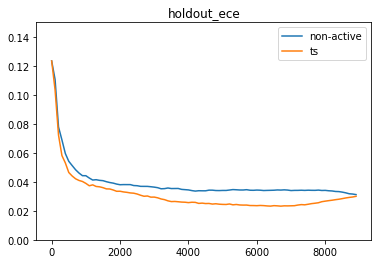

minimum of  holdout_ece with ts: 0.023210000799282995
holdout_ece evaluated on all holdout set: 0.029983428300289508
Percentage of drop: -22.59%


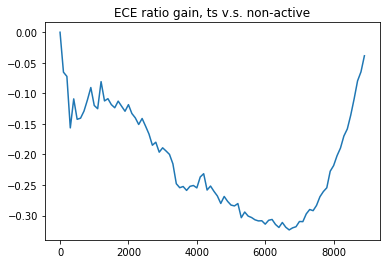

In [15]:
plt.figure()
for method in ['non-active', 'ts']:
    x = np.arange(len(holdout_ece_dict[method])) * LOG_FREQ
    plt.plot(x[:-1], holdout_ece_dict[method][:-1],label=method)
plt.ylim([0, 0.15])
plt.legend()
plt.title("holdout_ece")
plt.show()
ece_min = min(holdout_ece_dict['ts'][:-1])
ece_converge = holdout_ece_dict['ts'][-2]
print("minimum of  holdout_ece with ts:", ece_min)
print("holdout_ece evaluated on all holdout set:", ece_converge)
print("Percentage of drop:", '{:.2%}'.format((ece_min - ece_converge) / ece_converge))

ratio_gain = (holdout_ece_dict['ts'][:-1] - holdout_ece_dict['non-active'][:-1]) / holdout_ece_dict['non-active'][:-1]
plt.plot(x[:-1], ratio_gain)
plt.title('ECE ratio gain, ts v.s. non-active')
plt.show()

In [6]:
# percentage of samples from the least calibrate top 10 predicted classes
samples_in_ground_truth = {
    'non-active': np.empty(sampled_categories_dict[method].shape, dtype=bool),
    'ts': np.empty(sampled_categories_dict[method].shape, dtype=bool),
}
for method in ['non-active', 'ts']:
    for run_id in range(sampled_categories_dict[method].shape[0]):
        for i in range(sampled_categories_dict[method].shape[1]):
            samples_in_ground_truth[method][run_id, i] = ground_truth[sampled_categories_dict[method][run_id, i]]
    samples_in_ground_truth[method] = samples_in_ground_truth[method].mean(axis=0)

In [7]:
samples_in_ground_truth['ts'].shape

(9000,)

No handles with labels found to put in legend.


Text(0.5, 1.0, '#avg samples from ground truth top 10 least calibrated classes (at each step)')

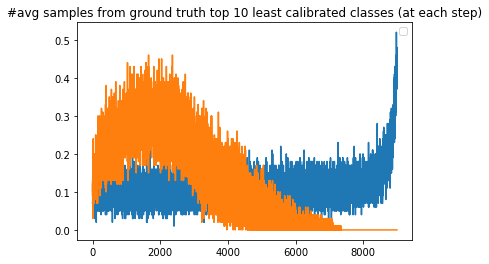

In [8]:
plt.figure()
for method in ['non-active', 'ts']:
    plt.plot(samples_in_ground_truth[method])
plt.legend()
plt.title("#avg samples from ground truth top 10 least calibrated classes (at each step)")

/Users/disiji/Dropbox/current/bayesian-blackbox/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/disiji/Dropbox/current/bayesian-blackbox/.venv/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.


Text(0.5, 1.0, 'cumulative percentage samples from ground truth top 10 least calibrated classes')

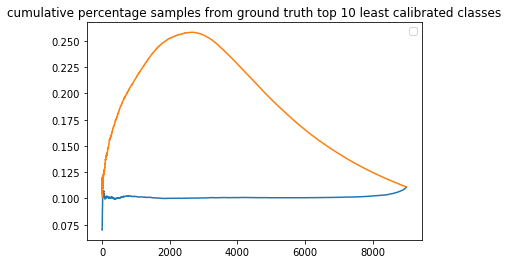

In [9]:
plt.figure()
for method in ['non-active', 'ts']:
    plt.plot([samples_in_ground_truth[method][:i].mean() for i in range(len(samples_in_ground_truth[method]))])
plt.legend()
plt.title("cumulative percentage samples from ground truth top 10 least calibrated classes")

In [10]:
num_bins = 10

def bayesian_assessment(confidences: np.ndarray,
                        observations: np.ndarray,
                        var: int = None,
                        pseudocount: int = None) -> Dict[str, np.ndarray]:
    bins = np.linspace(0, 1, num_bins + 1)
    digitized = np.digitize(confidences, bins[1:-1])
    
    density_bins = [(digitized == i).mean() for i in range(0, num_bins)]
    diagonal_bins = [(i + 0.5) / num_bins for i in range(0, num_bins)]
    
    beta_priors = np.array([[(i + 0.5) * pseudocount / 10, (9.5 - i) * pseudocount / 10] for i in range(num_bins)])

    counts = np.array([((observations[digitized == i]).sum(), 
                        (1-observations[digitized == i]).sum())
                       for i in range(num_bins)])
    empirical_accuracy = counts[:, 0] / (counts[:, 0] + counts[:, 1])
    empirical_accuracy[np.isnan(empirical_accuracy)] = 0
    beta_posteriors = beta_priors + counts

    # compute mean and credible interval of posterior
    beta_posteriors_mean = np.array([beta_posteriors[i, 0] / (beta_posteriors[i].sum())
                                     for i in range(num_bins)])
    beta_posterior_p025 = np.array([stats.beta.ppf(0.025, beta_posteriors[i, 0], beta_posteriors[i, 1])
                                    for i in range(num_bins)])
    beta_posterior_p975 = np.array([stats.beta.ppf(0.975, beta_posteriors[i, 0], beta_posteriors[i, 1])
                                    for i in range(num_bins)])
    return {
        'diagonal_bins': np.array(diagonal_bins),
        'density_bins': np.array(density_bins),
        'empirical_accuracy': empirical_accuracy,
        'beta_posteriors_mean': beta_posteriors_mean,
        'beta_posterior_p025': beta_posterior_p025,
        'beta_posterior_p975': beta_posterior_p975,
    }


def plot_bayesian_reliability_diagram(confidences: np.ndarray,
                                      observations: np.ndarray,
                                      var: int = None,
                                      pseudocount: int = None) -> None:
    output = bayesian_assessment(confidences, observations, var, pseudocount)

    fig, ax1 = plt.subplots(figsize=(4.3, 3))
    color = 'tab:red'
    # ax1.grid(True)
    ax1.scatter([i + 0.5 for i in range(num_bins)], output['empirical_accuracy'], label="Frequentist", marker="^",
                s=100)
    ax1.plot([i + 0.5 for i in range(num_bins)], output['beta_posteriors_mean'], c="r", linestyle="--")
    ax1.errorbar([i + 0.5 for i in range(num_bins)],
                 output['beta_posteriors_mean'],
                 yerr=(output['beta_posteriors_mean'] - output['beta_posterior_p025'],
                       output['beta_posterior_p975'] - output['beta_posteriors_mean']),
                 fmt='o', color='r', label="Bayesian")
    ax1.plot(np.linspace(0, 1, num_bins + 1), linestyle="--", linewidth=3, c="gray")
    ax1.fill_between([i + 0.5 for i in range(num_bins)], output['beta_posteriors_mean'], \
                     np.linspace(0, 1, num_bins + 1)[:-1] + 0.05, color="gray", alpha=0.3)
    ax1.set_xlim((0.0, num_bins))
    ax1.set_xlabel("Score(Model confidences)", fontsize=14)
    ax1.set_xticks(range(num_bins + 1))
    ax1.set_xticklabels(["%.1f" % i for i in np.linspace(0, 1, num_bins + 1)])
    ax1.set_ylim((0.0, 1.0))
    ax1.set_ylabel("Estimated Accuracy", fontsize=14)

    # add histogram to the reliability diagram
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.bar([i + 0.5 for i in range(num_bins)], output['density_bins'], color=color, alpha=0.5, label="Histogram",
            width=1.0)
    ax2.set_ylabel('Histogram', color=color, fontsize=12)
    ax2.set_ylim((0.0, 2.0))
    ax2.set_yticks([0, 1.0])
    ax2.set_yticklabels([0, 1.0], color=color)
    ax2.yaxis.set_label_coords(1.01, 0.25)
    plt.tight_layout()

/Users/disiji/Dropbox/current/bayesian-blackbox/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


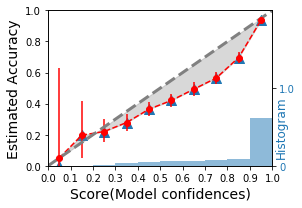

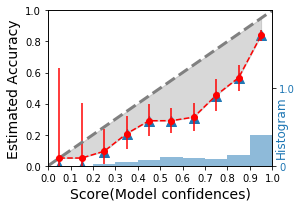

In [11]:
# ECE of topk least calibrated classes
least_calibrated_mask = [ground_truth[val] for val in categories]

categories_1 =np.array([categories[i] for i in range(len(categories)) if least_calibrated_mask[i] == True])
categories_0 = np.array([categories[i] for i in range(len(categories)) if least_calibrated_mask[i] == False])
observations_1 =np.array([observations[i] for i in range(len(observations)) if least_calibrated_mask[i] == True])
observations_0 = np.array([observations[i] for i in range(len(observations)) if least_calibrated_mask[i] == False])
confidences_1 =np.array([confidences[i] for i in range(len(confidences)) if least_calibrated_mask[i] == True])
confidences_0 = np.array([confidences[i] for i in range(len(confidences)) if least_calibrated_mask[i] == False])

plot_bayesian_reliability_diagram(confidences_0, observations_0, pseudocount=pseudocount)
plot_bayesian_reliability_diagram(confidences_1, observations_1, pseudocount=pseudocount)